**TEMA D'ESAME**

In questo Notebook è affrontato un esercizio di apprendimento automatico supervisionato, che consiste in un problema di classificazione binaria di immagini. All'interno di un dataset di addestramento sono contenute 4733 raffigurazioni opportunamente etichettate secondo due classi differenti, "muffin" e "chihuahua", sottoforma di immagini RGB di dimensioni e apparenza differenti: sono riportate fotografie, disegni stilizzati, schemi, etc. 

L'obiettivo consiste nell'addestrare un opportuno modello di apprendimento sul dataset di training, per poi valutare l'accuratezza delle etichette predette applicando tale modello sul dataset di test, costituito da 1184 immagini. L'accuratezza sarà dunque valutata come la percentuale di etichette predette per il dataset di test che corrispondono alle etichette assegnate dal dataset a tali immagini.

Si è scelto di utilizzare come modello di apprendimento una Random Forest. Nel corso del documento, il dataset viene caricato e poi ordinato in una matrice di vettori linearizzati, su cui si effettua una SVD per ricavare le componenti principali e i rispettivi valori singolari. Dopo aver applicato una Random Forest con una architettura non ottimizzata (partendo ad esempio da un numero di alberi decisionali pari a $100$ e un numero di componenti principali tale da includere il $90  \%$ della varianza), si applica una Feature Importance per poter selezionare le componenti principali più rilevanti alla determinazione dei predittori. Dunque, si effettua una ricerca della combinazione di iperparametri (in particolare il numero di alberi stimatori e il numero di componenti principali incluse) che massimizzano l'accuracy della Random Forest, prima con una ricerca $coarse-grain$ e poi con uno studio $fine-tuning$ che prevede l'utilizzo della K-Fold Cross Validation. Infine, si verifica la robustezza di tale architettura ottimizzata al variare di altri parametri della Random Forest, ad esempio il seed per il generatore di numeri pseudo-casuali e il numero massimo di Leaf Nodes.

**1. Caricamento del dataset di immagini**

Come primo passaggio è necessario estrarre il dataset di immagini RGB, standardizzarle ad una dimensione comune ($dim$,$dim$) e infine caricarle all'interno di un tensore di dimensioni ($N_{img}$, $dim$, $dim$,  $3$), dove $N_{img}$ è il numero totale di immagini, $dim$ è il numero di pixel per ogni lato dell'immagine e $3$ rappresenta il numero di canali RGB. Si è scelto di uniformare le immagini ad una forma quadrata con $dim = 75$. Questo numero rappresenta un compromesso ritenuto accettabile dallo sperimentatore tra la risoluzione (e di conseguenza la qualità) di ogni immagine e il costo computazionale necessario per l'analisi e l'addestramento di algoritmi su di essa.

In [1]:
import numpy as np
import pandas as pd
import math as mt

from IPython.display import display
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split

import glob
from PIL import Image

image_list = []
label_list = []  # muffin = 1, chihuahua = 0

# dimensione standardizzata dell'immagine
dim = 75
standard_size = (dim,dim)

datasets_divisions = np.zeros((4)) # vettore che riporta le dimensioni di ogni sotto-dataset

i = 0
for filename in glob.glob("archive/train/muffin/*.jpg"):
    im = Image.open(filename)  #lettura dell'immagine .jpg
    im = im.resize(standard_size)  # riscalamento dell'immagine ad una dimensione standardizzata
    im.load()                  #caricamento dell'immagine
    im = np.array(im)          #conversione dell'immagine in un tensore RGB di dimensioni ((standard_size),3)
    image_list.append(im/255.0)      #inserimento dell'immagine nel dataset
    label_list.append(1)       #inserimento dell'etichetta nel dataset
    if(i%100 == 0): print(f' Caricamento delle immagini train muffin in corso: completate le prime {i}', end = '\r')
    datasets_divisions[0] = i
    i = i + 1
print("--- Sono state caricate ", i, "immagini di train per il muffin ---             ")   
i = 0 
for filename in glob.glob("archive/test/muffin/*.jpg"):
    im = Image.open(filename)  #lettura dell'immagine .jpg
    im = im.resize(standard_size)  # riscalamento dell'immagine ad una dimensione standardizzata
    im.load()                  #caricamento dell'immagine
    im = np.array(im)          #conversione dell'immagine in un tensore RGB di dimensioni ((standard_size),3)
    image_list.append(im/255.0)      #inserimento dell'immagine nel dataset
    label_list.append(1)       #inserimento dell'etichetta nel dataset
    if(i%100 == 0): print(f' Caricamento delle immagini test muffin in corso: completate le prime {i}', end = '\r')
    datasets_divisions[1] = i
    i = i + 1
print("--- Sono state caricate ", i, "immagini di test per il muffin ---             ")
i = 0    
for filename in glob.glob("archive/train/chihuahua/*.jpg"):
    im = Image.open(filename)  #lettura dell'immagine .jpg
    im = im.resize(standard_size)  # riscalamento dell'immagine ad una dimensione standardizzata
    im.load()                  #caricamento dell'immagine
    im = np.array(im)          #conversione dell'immagine in un tensore RGB di dimensioni ((standard_size),3)
    image_list.append(im/255.0)      #inserimento dell'immagine nel dataset
    label_list.append(0)       #inserimento dell'etichetta nel dataset
    if(i%100 == 0): print(f' Caricamento delle immagini train chihuahua in corso: completate le prime {i}', end = '\r')
    datasets_divisions[2] = i
    i = i + 1
print("--- Sono state caricate ", i, "immagini di train per il chihuahua ---           ") 
i = 0
for filename in glob.glob("archive/test/chihuahua/*.jpg"):
    im = Image.open(filename)  #lettura dell'immagine .jpg
    im = im.resize(standard_size)  # riscalamento dell'immagine ad una dimensione standardizzata
    im.load()                  #caricamento dell'immagine
    im = np.array(im)          #conversione dell'immagine in un tensore RGB di dimensioni ((standard_size),3)
    image_list.append(im/255.0)      #inserimento dell'immagine nel dataset
    label_list.append(0)       #inserimento dell'etichetta nel dataset
    if(i%100 == 0): print(f'Caricamento delle immagini test chihuahua in corso: completate le prime {i}', end = '\r')
    datasets_divisions[3] = i
    i = i + 1
print("--- Sono state caricate ", i, "immagini di test per il chihuahua ---           ")

#print("Hello World")
#Riportare la suddivisione del dataset, distinguendo i sotto-dataset in base alla classe e al test/train


--- Sono state caricate  2174 immagini di train per il muffin ---             
--- Sono state caricate  544 immagini di test per il muffin ---             
--- Sono state caricate  2559 immagini di train per il chihuahua ---           
--- Sono state caricate  640 immagini di test per il chihuahua ---           


E' opportuno, a titolo di esempio, raffigurare una delle immagini caricate, per verificarne la corretta conversione in un tensore RGB. Si osserva che alcune delle immagini estratte dal dataset, corrispondenti a schemi e disegni in bianco e nero, non sono automaticamente salvate in formato RGB, operazione che viene quindi effettuata manualmente.

<class 'numpy.ndarray'>
Le immagini sono state salvate in un tensore di dimensioni:  (5917, 75, 75, 3)


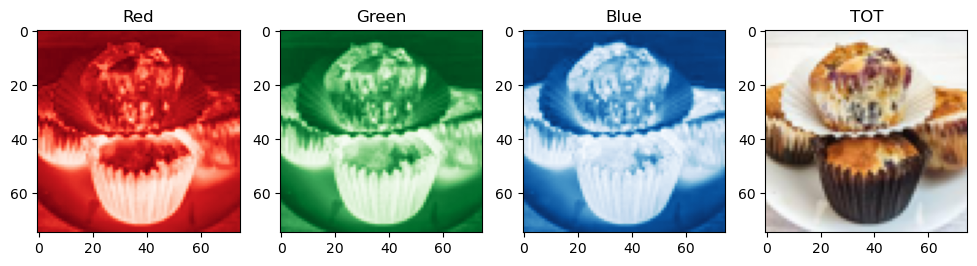

In [2]:
from matplotlib import pyplot as plt

n_inputs = len(image_list)

#si carica la lista in un tensore di rango 4: (numero di immagini, righe, colonne, colori)
X = np.zeros(( n_inputs , dim, dim, 3 ))

# carico nel tensore le immagini che sono già in formato RGB: tutte tranne le: 2669 , 3144, 3163, 3274
for i in range(0,2669):
    X[i,:,:,:] = np.array(image_list[i])
    
for i in range(2670,3144):
    X[i,:,:,:] = np.array(image_list[i])

for i in range(3145,3163):
    X[i,:,:,:] = np.array(image_list[i])
    
for i in range(3164,3274):
    X[i,:,:,:] = np.array(image_list[i])
    
for i in range(3275,n_inputs):
    X[i,:,:,:] = np.array(image_list[i])
    
# correggo le immagini che non sono state precedentemente caricate in formato RGB, poichè sono disegni in bianco e nero
for j in range(0,3):
    X[2669,:,:,j] = np.array(image_list[2669])
    X[3144,:,:,j] = np.array(image_list[3144])
    X[3163,:,:,j] = np.array(image_list[3163])
    X[3274,:,:,j] = np.array(image_list[3274])

print(type(X))

print("Le immagini sono state salvate in un tensore di dimensioni: ", np.shape(X))
n_images, dim, dim, n_colors = X.shape

Y = np.array(label_list)

plt.figure(figsize=(12, 6))

n_example = 352

plt.subplot(141)
plt.imshow(X[n_example,:,:,0], cmap='Reds')
plt.title("Red")

plt.subplot(142)
plt.imshow(X[n_example,:,:,1] , cmap = 'Greens')
plt.title("Green")

plt.subplot(143)
plt.imshow(X[n_example,:,:,2] , cmap = 'Blues')
plt.title("Blue")

plt.subplot(144)
plt.imshow(X[n_example,:,:,:])
plt.title("TOT")

plt.show()



Successivamente, si inizia a indagare la distribuzione statistica dei dati, al fine di poter in seguito effettuare una riduzione della dimensionalità attravaerso SVD/PCA. Innanzitutto, è utile visualizzare la distribuzione della varianza, calcolata su tutte le immagini del dataset, dei singoli pixel.

--- Il dataset è stato deformato in un tensore di dimesnioni:  (75, 75, 5917, 3)
Esempio di immagine


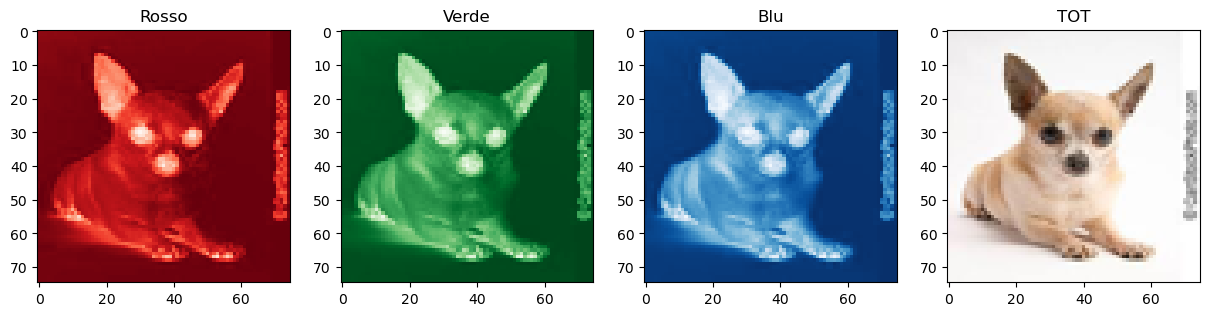

In [3]:
# Varianza dei pixel delle immagini nel dataset di partenza

# Per richiamare la funzione np.var devo effettuare un reshaping del dataset
X_s = np.transpose(X , (1,2,0,3)).reshape((dim,dim,n_images,n_colors))
#X_s = X.reshape((dim,dim,n_images,n_colors))

# Verifico che il reshaping abbia riordinato correttamente i dati, permettendomi di visualizzare ancora le immaggini
print("--- Il dataset è stato deformato in un tensore di dimesnioni: ", np.shape(X_s))

fig, axs = plt.subplots(1, 4, figsize=(15,5))

print("Esempio di immagine")
n_exmpl = 3420

# Rosso
im1 = axs[0].imshow(X_s[: , : , n_exmpl, 0], cmap = 'Reds')
axs[0].set_title("Rosso")

# Verde
im2 = axs[1].imshow(X_s[: , : , n_exmpl, 1], cmap = 'Greens')
axs[1].set_title("Verde")

# Blu
im1 = axs[2].imshow(X_s[: , : , n_exmpl, 2], cmap = 'Blues')
axs[2].set_title("Blu")

# TOT
im1 = axs[3].imshow(X_s[: , : , n_exmpl, :])
axs[3].set_title("TOT")

plt.show()

Varianza per ogni pixel


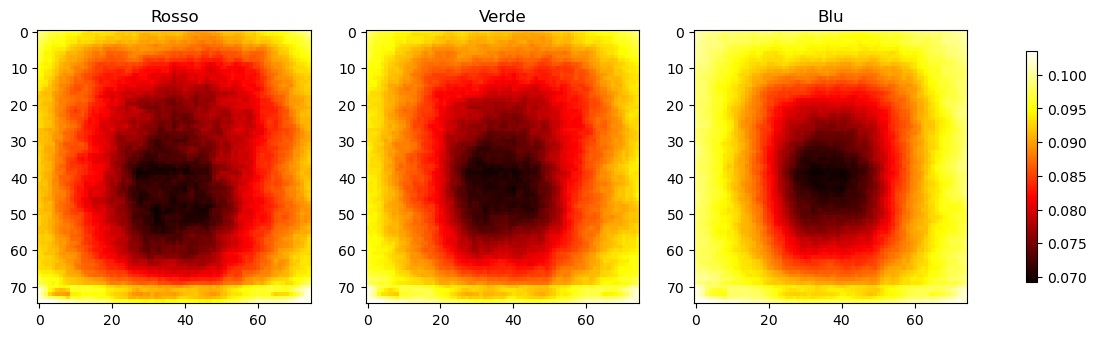

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

print("Varianza per ogni pixel")

# Rosso
im1 = axs[0].imshow(np.var(X_s[:, :, :, 0], axis = 2) , cmap = 'hot')
axs[0].set_title("Rosso")

# Verde
im2 = axs[1].imshow(np.var(X_s[:, :, :, 1], axis = 2) , cmap = 'hot')
axs[1].set_title("Verde")

# Blu
im1 = axs[2].imshow(np.var(X_s[:, :, :, 2], axis = 2), cmap = 'hot')
axs[2].set_title("Blu")

cbar = fig.colorbar(axs[0].imshow(np.var(X_s[:, :, :, 0] , axis = 2) , cmap = 'hot') , ax = axs, shrink = 0.6)
plt.show()

Dalle matrici appena visualizzate, emerge una grave problematica: i pixel con maggiore varianza sono quelli concentrati ai bordi dell'immagine. Questo è dovuto principalmente alla disuniformità dei background delle immagini, nelle quali posso avere, ad esempio, il disegno di un chihuahua sul fondo bianco oppure la fotografia del cane sul fondo erboso. 

Sarebbe possibile, almeno in teoria, implementare una funzione di rimozione del fondo, che in seguito viene riportata commentata. In questo particolare Notebook si è scelto quindi di rinunciare ad effettuare un background removal, poichè, nonostante il suo elevato costo computazionale, non porta ad un effettivo miglioramento dell'accuratezza dell'algoritmo Random Forest in seguito applicato.

In [5]:
print("Codice commentato: la rimozione del background non è stata effettuata ")

'''
def background_removal(image,dim, m_size):
    # m_size è la dimensione della maschera
    m_size = int(m_size)
    image2 = np.zeros(np.shape(image))
    for i in range(0, dim-m_size): #identifico la riga di inizio della maschera 
        for j in range(0,dim-m_size): #identifico la colonna di inizio della maschera 
            
            mask = image[i:i+m_size , j:j+m_size]
            m_var = np.var(mask)
            m_sum = 0
            
            for l in range(0,m_size): #mi muovo sulle righe della maschera (i,j)
                for s in range(0,m_size): #mi muovo sulle colonne della maschera (i,j)
                    m_sum = m_sum + mask[l ,s]
            
            m_sum = m_sum / (m_size * m_size)
            if(m_var / float(m_sum) < 0.015):
                image2[i,j] = 0
                #if(m_var ==0): print("ERR")
            else:
                image2[i,j] = image[i,j]
                
    return image2

X_clean = np.zeros((n_images,dim,dim,n_colors))
for i in range(0,n_images):
    if(i%20 == 0): print(f'Elaborazione delle immagini in corso: completate le prime {i}', end = '\r')
    for j in range(0,3):
        X_clean[i,:,:,j] = background_removal(X[i,:,:,j], dim, 5)
        
#plt.imshow(X_clean[6,:,:,:])
plt.show()
    

# Per confrontare le immagini con e senza background removal, grafico 4 esempi
fig, axs = plt.subplots(4, 4, figsize=(15,17))

print("Esempio di immagini prima e dopo la pulizia")
n_exmpl = 7

# 1
im1 = axs[0,0].imshow(X[n_exmpl , : ,:, :])
axs[0,0].set_title("Image 1")

# 2
im2 = axs[0,1].imshow(X[n_exmpl+1 , : ,:, :])
axs[0,1].set_title("Image 2")

# 3
im3 = axs[0,2].imshow(X[n_exmpl+2 , : ,:, :])
axs[0,2].set_title("Image 3")

# 4
im4 = axs[0,3].imshow(X[n_exmpl+3 , : ,:, :])
axs[0,3].set_title("Image 4")

# 1 pulita
im5 = axs[1,0].imshow(X_clean[n_exmpl , : ,:, :])
axs[1,0].set_title("Clean Image 1")

# 2 pulita
im6 = axs[1,1].imshow(X_clean[n_exmpl+1 , : ,:, :])
axs[1,1].set_title("Clean Image 2")

# 3 pulita
im7 = axs[1,2].imshow(X_clean[n_exmpl+2 , : ,:, :])
axs[1,2].set_title("Clean Image 3")

# 4 pulita
im8 = axs[1,3].imshow(X_clean[n_exmpl+3 , : ,:, :])
axs[1,3].set_title("Clean Image 4")

# 5
im9 = axs[2,0].imshow(X[n_exmpl+4 , : ,:, :])
axs[2,0].set_title("Image 5")

# 6
im10 = axs[2,1].imshow(X[n_exmpl+5 , : ,:, :])
axs[2,1].set_title("Image 6")

# 7
im11 = axs[2,2].imshow(X[n_exmpl+6 , : ,:, :])
axs[2,2].set_title("Image 7")

# 8
im12 = axs[2,3].imshow(X[n_exmpl+7 , : ,:, :])
axs[2,3].set_title("Image 8")

# 5 pulita
im13 = axs[3,0].imshow(X_clean[n_exmpl+4 , : ,:, :])
axs[3,0].set_title("Clean Image 5")

# 6 pulita
im14 = axs[3,1].imshow(X_clean[n_exmpl+5 , : ,:, :])
axs[3,1].set_title("Clean Image 6")

# 7 pulita
im15 = axs[3,2].imshow(X_clean[n_exmpl+6 , : ,:, :])
axs[3,2].set_title("Clean Image 7")

# 8 pulita
im16 = axs[3,3].imshow(X_clean[n_exmpl+7 , : ,:, :])
axs[3,3].set_title("Clean Image 8")

plt.show()
'''

Codice commentato: la rimozione del background non è stata effettuata 


'\ndef background_removal(image,dim, m_size):\n    # m_size è la dimensione della maschera\n    m_size = int(m_size)\n    image2 = np.zeros(np.shape(image))\n    for i in range(0, dim-m_size): #identifico la riga di inizio della maschera \n        for j in range(0,dim-m_size): #identifico la colonna di inizio della maschera \n            \n            mask = image[i:i+m_size , j:j+m_size]\n            m_var = np.var(mask)\n            m_sum = 0\n            \n            for l in range(0,m_size): #mi muovo sulle righe della maschera (i,j)\n                for s in range(0,m_size): #mi muovo sulle colonne della maschera (i,j)\n                    m_sum = m_sum + mask[l ,s]\n            \n            m_sum = m_sum / (m_size * m_size)\n            if(m_var / float(m_sum) < 0.015):\n                image2[i,j] = 0\n                #if(m_var ==0): print("ERR")\n            else:\n                image2[i,j] = image[i,j]\n                \n    return image2\n\nX_clean = np.zeros((n_images,di

Si potrebbe ripetere l'analisi della varianza se si decidesse di effettuare il background removal:

In [6]:
print("Codice commentato: non è effettuata l analisi della varianza dopo il background removal")

'''
# Varianza dei pixel delle immagini nel dataset ripulito del fondo

# Per richiamare la funzione np.var devo effettuare un reshaping del dataset
X_s = np.transpose(X_clean , (1,2,0,3)).reshape((dim,dim,n_images,n_colors))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

print("Varianza per ogni pixel")

# Rosso
im1 = axs[0].imshow(np.var(X_s[:, :, :, 0], axis = 2) , cmap = 'hot')
axs[0].set_title("Rosso")

# Verde
im2 = axs[1].imshow(np.var(X_s[:, :, :, 1], axis = 2) , cmap = 'hot')
axs[1].set_title("Verde")

# Blu
im1 = axs[2].imshow(np.var(X_s[:, :, :, 2], axis = 2), cmap = 'hot')
axs[2].set_title("Blu")

cbar = fig.colorbar(axs[0].imshow(np.var(X_s[:, :, :, 0] , axis = 2) , cmap = 'hot') , ax = axs, shrink = 0.6)
plt.show()
'''

Codice commentato: non è effettuata l analisi della varianza dopo il background removal


'\n# Varianza dei pixel delle immagini nel dataset ripulito del fondo\n\n# Per richiamare la funzione np.var devo effettuare un reshaping del dataset\nX_s = np.transpose(X_clean , (1,2,0,3)).reshape((dim,dim,n_images,n_colors))\n\nfig, axs = plt.subplots(1, 3, figsize=(15,5))\n\nprint("Varianza per ogni pixel")\n\n# Rosso\nim1 = axs[0].imshow(np.var(X_s[:, :, :, 0], axis = 2) , cmap = \'hot\')\naxs[0].set_title("Rosso")\n\n# Verde\nim2 = axs[1].imshow(np.var(X_s[:, :, :, 1], axis = 2) , cmap = \'hot\')\naxs[1].set_title("Verde")\n\n# Blu\nim1 = axs[2].imshow(np.var(X_s[:, :, :, 2], axis = 2), cmap = \'hot\')\naxs[2].set_title("Blu")\n\ncbar = fig.colorbar(axs[0].imshow(np.var(X_s[:, :, :, 0] , axis = 2) , cmap = \'hot\') , ax = axs, shrink = 0.6)\nplt.show()\n'

Dunque, si è deciso di lavorare con le immagini originarie, senza operare una rimozione del fondo che porterebbe a produrre un dataset diverso da quello di partenza.

In seguito, ogni singola immagine necessita di essere convertita in un vettore lineare di caratteristiche, al fine di poter rappresentare il dataset in una matrice di design $X$ di dimensioni $(n_{inputs}, P)$, con $P = 50^2 * 3$ alla quale è associato un vettore di etichette $Y$, le quali assumono valore $1$ per la classe "Muffin" e valore $0$ per la classe "Chihuahua".

In [7]:
X_design = X.reshape(n_inputs, dim*dim*3)

# Verifico che effettivamente ogni immagine sia stata linearizzata in un vettore di P = dim*dim*3 caratteristiche
P = len(X_design[0,:])
print("L'immagine è stata convertita in un vettore di dimensioni: ", P)

#Suddivido il dataset complessivo in training e test, secondo la suddivisione dettata dalla directory di input
def canonical_train_test_split(X_design):
    X_train = np.concatenate( (X_design[0:2174] , X_design[2718:5277] ) , axis = 0)
    X_test = np.concatenate( (X_design[2174:2718] , X_design[5277:n_inputs] ) , axis = 0)
    Y_train = np.concatenate( (Y[0:2174] , Y[2718:5277] ) , axis = 0)
    Y_test = np.concatenate( (Y[2174:2718] , Y[5277:n_inputs] ) , axis = 0)
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = canonical_train_test_split(X_design)

print("Il dataset di training è un tensore di dimensioni" , np.shape(X_train))
print("Il dataset di test è un tensore di dimensioni" , np.shape(X_test))

L'immagine è stata convertita in un vettore di dimensioni:  16875
Il dataset di training è un tensore di dimensioni (4733, 16875)
Il dataset di test è un tensore di dimensioni (1184, 16875)


Una volta caricate le immagini in una matrice di Design, si procede ad effettuare la SVD/PCA dei dati, rappresentati come punti nello spazio $R^P$.

**2. Riduzione della dimensionalità e analisi della relazione varianza-componenti principali**

Applicando la decomposizione ai valori singolari (SVD), è possibile riscrivere la matrice di Design $X$ di dimensioni $N x P$ su una base di vettori singolari. 

In particolare, esiste per $X$ la seguente decomposizione:

$X = U \Sigma V^T$

dove:

1. $U$ è la matrice $N x N$ che ha sulle colonne i vettori singolari sinistri, ovvero gli assi principali dello spazio delle istanze $R^N$. Gli autovettori sono riportati in ordine descrescente rispetto al loro valore singolare.

2. $V$ è la matrice $P x P$ che ha sulle colonne i vettori singolari destri, ovvero gli assi principali dello spazio delle caratteristiche $R^P$. Gli autovettori sono riportati in ordine descrescente rispetto al loro valore singolare.

3. $\Sigma$ è la matrice $N x P$ che ha lungo gli elementi diagonali i valori singolari.

Se riscrivo la matrice di design sottratta della sua media $<X>$ (con $<X>_{ij} = 1/N * \sum_i^N x_{ij}$), allora vale la seguente relazione per la matrice di covarianza:

$X^T X = V \Sigma^T U^T U \Sigma V^T  = V D V^T$

dove $D$ è la matrice diagonale che, dal prodotto matriciale $\Sigma^T \Sigma$, ha elementi $D_{kk}$ pari al quadrato dei valori singolari $k$-esimi. Di fatto, l'equazione appena considerata consiste nella proiezione della covarianza su una base di vettori singolari dello spazio $R^P$, per cui i quadrati dei valori singolari sono semplicemente gli autovalori della covarianza sulla base di assi principali, vale a dire le varianze dei dati lungo tali direzioni.

Dunque, moltiplicando $X$ per la matrice $V$, si effettua la proiezione dei dati su una base di vettori singolari:

$X' = X V$

Quindi, ogni istanza è riscritta come vettore di componenti rispetto agli assi principali, ordinate in maniera decrescente rispetto alla varianza associata ad ogni asse. In seguito, sarà possibile effettuare una riduzione della dimensionalità rimuovendo le colonne a destra della matrice, associate ad assi principali con minore varianza.

Si sceglie di effettuare la PCA prendendo le componenti principali del solo dataset di training:

In [8]:
# Traslazione del dataset di addestramento nel baricentro
X_train2 = X_train - X_train.mean(axis=0)

# Decomposizione ai valori singolari
U, sigm, Vt = np.linalg.svd(X_train2)

# E' necessario centrare il dataset globale usando la media di X_train
X_design2 = X_design - X_train.mean(axis=0)

# Proietto la matrice di design sulla base dei vettori singolari
X_new = X_design2.dot(Vt.T)

La matrice di design è stata ora rappresentata su una base di vettori singolari, per cui le singole istanze sono date da vettori le cui componenti $j$-esime sono ordinate in maniera decrescente rispetto alla varianza del dataset lungo l'asse principale $j$-esimo.

E' utile studiare gli autovalori della covarianza, rappresentati dagli elementi (tutti diagonali) della matrice $\Sigma$, per comprendere come evolve, all'aumentare del numero di componenti principali considerate, la frazione di varianza inclusa.

In [9]:
tot_var = 0
tot_var_vec = np.zeros(( 1,P ))

comp_vec = np.zeros(( 1,P ))


for i in range(0,len(sigm)):
    tot_var = tot_var + sigm[i]*sigm[i]   # sigm è la matrice che riporta sulla diagonale i valori singolari
    tot_var_vec[0,i] = tot_var
    comp_vec[0,i] = i

Si determina quindi il numero di componenti principali che è necessario salvare per includere una certa percentuale della varianza, ad esempio il $90 \%$. Il dataset è quindi proiettato sul sottospazio rappresentato dai vettori singolari che contengono tale frazione di varianza, ottenendo quindi una riduzione della dimensionalità.

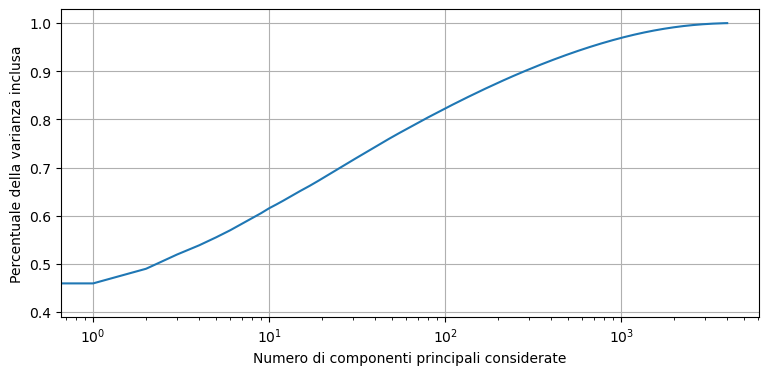

Si sceglie di lavorare includendo il  90.0 % della varianza, corrispondente al seguente numero di feature:  285
La nuova matrice di training, linearizzata sulle componenti principali, ha dimensioni:  (4733, 285)


In [10]:
plt.figure(figsize=(9,4))
plt.plot(tot_var_vec[0,1:4000]/tot_var)
plt.ylabel("Percentuale della varianza inclusa")
plt.xlabel("Numero di componenti principali considerate")
plt.xscale('log')
plt.grid(True)
plt.show()

from sklearn.decomposition import PCA

#pca = PCA()
#pca.fit(X_design[1:100,:])

#Determinazione del numero di componenti principali che conservano il 95% della varianza:

def max(x, y):
    if(x < y):
        return x
    else:
        return y
    
def find_principal(var_percentage, tot_var_vec, tot_var, P):
    index_component = 0
    minimum = 1000;
    for i in range(0,P):
        if(abs(tot_var_vec[0,i]/tot_var - var_percentage) <  minimum   ):
            index_component = i
            minimum = abs(tot_var_vec[0,i]/tot_var - var_percentage)
    P2 = index_component + 1 #numero di componenti principali da conservare
    return P2

var_percentage = 0.9    
P2 = find_principal(var_percentage, tot_var_vec, tot_var, P)

print("Si sceglie di lavorare includendo il ", var_percentage*100 , "% della varianza, corrispondente al seguente numero di feature: " , P2)

#Riduzione della dimensionalità: il dataset è proiettato sul sottospazio dato dai primi P2 vettori singolari che conservano il
#90 % della varianza:

def dimensionality_red(X_design, Vt, P2):
    X_design2 = X_design - X_train.mean(axis=0)
    return X_design2.dot(Vt.T[: , 0:P2])

X_new = dimensionality_red(X_train, Vt, P2)
print("La nuova matrice di training, linearizzata sulle componenti principali, ha dimensioni: " , np.shape(X_new))

**3. Implementazione della Random Forest e studio della Feature importance**

Una volta che si è completata la preparazione del dataset, si procede ad implementare il modello di apprendimento, che consiste in una Random Forest. 
Innanzitutto, si decide di svolgere l'operazione partendo da una architettura con iperparametri fissati, con l'obiettivo di effettuare una indagine preliminare delle prestazioni della Random Forest, includendo inizialmente il $90 \%$ della varianza. In particolare, si decide di fissare il numero di alberi decisionali che costituiscono l'ensemble, oltre che gli iperparametri dei singoli alberi, imponendo un numero di leaf nodes costante.

Inoltre, si consideri il meccanismo di costruzione di ogni albero decisionale che compone la Random Forest:
1. Bootstrapping: il dataset di addestramento su cui lavora il singolo albero è costruito estraendo casualmente ogni singola istanza dal dataset di addestramento iniziale, per cui un singolo dato può essere ripetuto più volte o essere del tutto assente nella nuova matrice di Design del training.
2. Feature selection: il singolo albero utilizza solamente un numero limitato di feature, estratte dalle componenti principali del dataset.

Queste caratteristiche introducono un elemento di stocasticità per la Random Forest, per cui, se si applica l'ensemble più volte al medesimo dataset, pur tenendo fissati gli stessi iperparametri, i risultati sono differenti.
Tuttavia, per valutare le prestazioni della Random Forest in funzione degli iperparametri, sono necessarie misure ripetibili, per cui si impone un $random \ state$ fissato, affinchè gli alberi decisionali che costituiscono l'Ensemble siano estratti con gli stessi numeri pseudo-casuali.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dichiarata una Random Forest di 100 alberi, senza imporre ulteriori iperparametri (ad es. max_leaf_nodes) 
rnd_clf = RandomForestClassifier(n_estimators = 100 , random_state = 47, n_jobs = -1, criterion='gini')

#Riduco la dimensionalità dei dataset così suddivisi, in accordo con il numero di componenti principali selezionato
X_train_ = dimensionality_red(X_train, Vt, P2)
X_test_ = dimensionality_red(X_test, Vt, P2)

# Addestramento della Random Forest sul dataset di training
rnd_clf.fit(X_train_,Y_train)

# Applicazione della Random Forest sul dataset di test
Y_pred = rnd_clf.predict(X_test_)

# L'accuratezza delle predizioni sul dataset di test è riportata in output
print("Si ottiene una accuracy pari a: ", accuracy_score(Y_test,Y_pred))

Si ottiene una accuracy pari a:  0.793918918918919


Da questa prima implementazione, si osserva una accuratezza nel predirre le etichette del dataset di test pari a oltre il 70%. Le motivazioni che possono ridurre tale percentuale di successo si possono imputare sia alle caratterisiche del dataset di partenza che alla costruzione della Random Forest. 

Infatti, una prima osservazione qualitativa inerente alle immagini di input riguarda la notevole disomogeneità delle stesse; a titolo di esempio, il dataset relativo alle istanze etichettate come "chihuahua" contiene numerose immagini che non sono fotografie del soggetto in questione, bensì disegni stilizzati o, addirittura, soggetti che un essere umano difficilmente classificherebbe come "chihuahua". Inoltre, anche la decisione di comprimere le immagini ad una dimensione standard di $(75,75)$ pixel, utile per non aggravare il tempo computazionale del Notebook, ha potenzialmente contribuito a peggiorare la qualità del dataset.

Tuttavia, un'influenza decisiva per l'accuratezza delle predizioni è data dalla scelta dell'architettura della Random Forest. Tale ensemble decisionale è costituito da un numero preciso di alberi decisionali, ciascuno dei quali fornisce, data un'istanza di test, un'etichetta indipendente, dopo che l'albero è stato addestrato su un dataset costruito con Bootstrapping e Feature Selection a partire dal dataset di training iniziale. Dal momento che solo alcune feature sono estratte casualmente per addestrare ciascuno degli alberi della Random Forest, l'impiego di caratteristiche poco rilevanti ai fini della classificazione rischia di rendere la Random Forest altamente inefficiente.

Quindi, è doveroso effettuare uno studio relativo alla Feature Importance, con l'obiettivo di identificare le caratteristiche più rilevanti nella determinazione delle etichette.

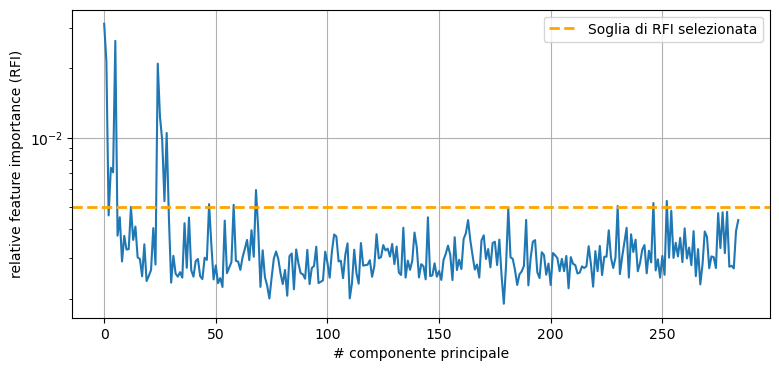

In [12]:
plt.figure(figsize=(9,4))
plt.plot(rnd_clf.feature_importances_)
plt.axhline(y = 5e-3, color = 'orange', linestyle = '--', linewidth = 2, label = 'Soglia di RFI selezionata')
plt.xlabel("# componente principale")
plt.ylabel("relative feature importance (RFI)")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

Il grafico appena visualizzato riporta sull'asse delle ascisse il numero associato alla feature (le caratteristiche sono i vettori singolari estratti con la SVD/PCA e sono quindi ordinate in maniera decrescente in base alla varianza) e sulle ordinate la Feature Importance normalizzata associata alla feature in questione. E' utile domandarsi quale sia la correlazione tra la feature importance delle singole caratteristiche e la varianza associata ai vettori singolari lungo tali direzioni.

Per visualizzare l'importanza dei singoli pixel nel predirre l'etichetta, è utile effettuare la Feature Importance non tanto sulle componenti principali, ma sulle immagini di partenza, al fine di evidenziare eventuali correlazioni tra la varianza dei pixel e la loro importanza.

Feature Importance


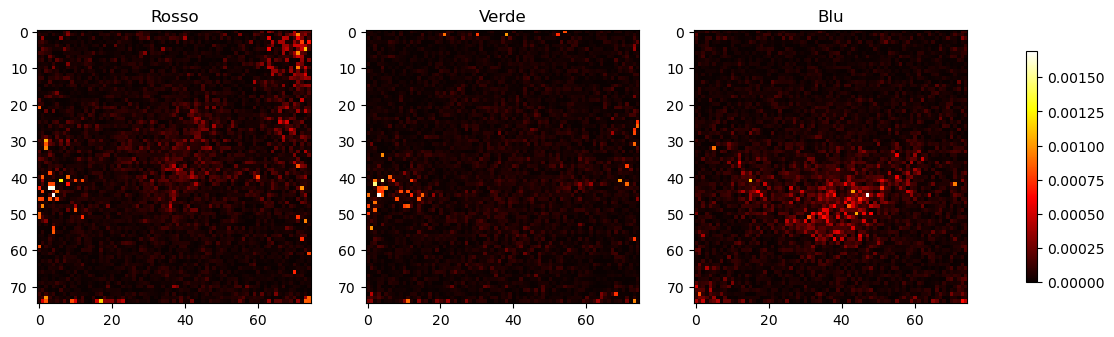

In [13]:
# Feature importance del dataset ripulito
print("Feature Importance")
RF = rnd_clf.fit(X_design,Y)
feature_importance_matrix = RF.feature_importances_.reshape(dim,dim,3)

fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Rosso
im1 = axs[0].imshow(feature_importance_matrix[:,:,0], cmap = 'hot')
axs[0].set_title("Rosso")

# Verde
im2 = axs[1].imshow(feature_importance_matrix[:,:,1], cmap = 'hot')
axs[1].set_title("Verde")

# Blu
im1 = axs[2].imshow(feature_importance_matrix[:,:,2], cmap = 'hot')
axs[2].set_title("Blu")

cbar = fig.colorbar(axs[0].imshow(feature_importance_matrix[:,:,0] , cmap = 'hot') , ax = axs, shrink = 0.6)
plt.show()

Appurata l'assenza di una evidente correlazione tra l'importanza dei pixel nella predizione e la loro varianza, si torna a considerare la Feature Importance applicata alle componenti principali.

Dopo aver misurato l'importanza di ogni feature (componente principale), questa informazione può essere utilizzata per ottimizzare l'architettura della Random Forest, imponendo di effettuare la Feature Selection solamente tra le caratteristiche di maggiore importanza. 

Questa prima misurazione della feature importance è importante anche se effettuata su un modello non ottimizzato, poichè, per modelli sempre più ottimizzati al variare dell'architettura, si ottengono Feature importance che convergeranno a valori limite, per la legge dei grandi numeri.

In [14]:
from sklearn.feature_selection import SelectFromModel

# Selezione delle feature in base alla loro importanza
feature_selector = SelectFromModel(rnd_clf, threshold = 5e-3)
feature_selector.fit(X_train_, Y_train)

# Creazione di un nuvo dataset che riporta le feature più importanti
X_train_selected = feature_selector.transform(X_train_)
X_test_selected = feature_selector.transform(X_test_)

# Addestramento della Random Forest
rnd_clf.fit(X_train_selected, Y_train)

# L'accuratezza delle predizioni sul dataset di test è riportata in output
#print("Si ottiene una accuracy pari a: ", accuracy_score(Y_test,Y_pred))
print("Si ottiene un'accuracy pari a: " ,  rnd_clf.score(X_test_selected, Y_test))

Si ottiene un'accuracy pari a:  0.8099662162162162


Si osserva immediatamente come l'imposizione di una soglia di Feature Importance, che restringe la collezione di componenti principali su cui effettuare la Feature Selection, non comporti un miglioramento significativo dell'accuratezza della Random Forest. 

Tuttavia, questa tipologia di constraint è mantenuta nella successiva sezione, quando si opera una K-fold Cross validation per ottimizzare l'architettura della Random Forest. L'obiettivo di tale inclusione non è tanto l'identificazione di un numero di feature mantenute per massimizzare l'accuracy, quanto la riduzione della dimensione complessiva del dataset, che porta ad un minore costo computazionale. Si è deciso di fissare la soglia di relative feature importance per includere una data feature a $4*10^{-3}$, per ridurre la dimensione del dataset senza rischiare di far perdere eccessivamente generalità all'algoritmo.

**4. Studio dell'accuratezza al variare degli iperparametri**

Ora, si procede a valutare le prestazioni della Random Forest al variare di due iperarametri:
1. Il numero di alberi decisionali usati come stimatori
2. Il numero di componenti principali incluse nel dataset di partenza

Si comincia con una semplice ricerca $coarse-grain$, che consiste nell'addestrare una Random Forest sull'intero dataset di training e valutarne l'accuracy sul dataset di test per ogni combinazione dei due iperparametri selezionata su una data griglia di valori.

(6, 5)
xlabel =                [80, 100, 200, 500, 600]
ylabel =                [50, 100, 200, 500, 700, 800]


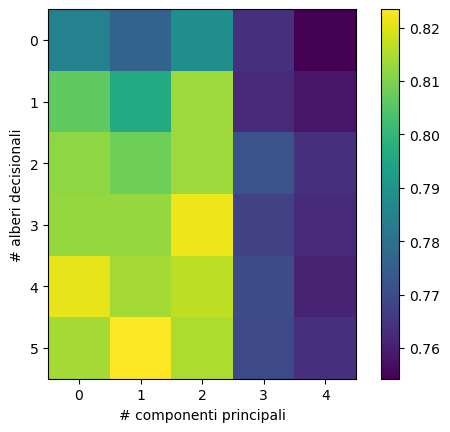

In [15]:
X_train, X_test, Y_train, Y_test = canonical_train_test_split(X_design)


estimator_range = [50, 100, 200, 500, 700, 800]  #valori del numero di alberi decisionali
components_range = [80, 100, 200, 500, 600]  #valori del numero di componenti principali incluse

# il risultato dell'ottimizzazione coarse-grain degli iperparametri è una heatmap che riporta l'accuracy in funzione di essi
accuracy_matrix = np.zeros((len(estimator_range) , len(components_range)))
print(np.shape(accuracy_matrix))
i1 = 0          # serve solo come contatore per il messaggio di output
for i in estimator_range:
    j1 = 0      #serve solo come contatore per il messaggio di output
    for j in components_range:
        # riduco la dimensionalità in base al numero j di componenti principali
        X_train_red = dimensionality_red(X_train, Vt, j)
        X_test_red = dimensionality_red(X_test, Vt, j)
        
        #Definisco la random forest con il numero i di alberi decisionali
        RF = RandomForestClassifier(n_estimators = i , random_state = 47, n_jobs = -1, criterion='gini')
        
        # Selezione delle feature in base alla loro importanza
        feature_selector = SelectFromModel(rnd_clf, threshold = 5e-3)
        feature_selector.fit(X_train_red, Y_train)

        # Creazione di un nuvo dataset che riporta le feature più importanti
        X_train_selected = feature_selector.transform(X_train_red)
        X_test_selected = feature_selector.transform(X_test_red)

        # Addestramento della Random Forest
        RF.fit(X_train_selected, Y_train)
        
        Y_pred = RF.predict(X_test_selected)
        accuracy_matrix[i1 , j1] = accuracy_score(Y_test, Y_pred)
        print(f'Eseguita la Random Forest numero {(i1 + 1,j1 + 1)}/(6,5)' , end = '\r')
        j1 = j1 + 1
    i1 = i1 + 1
       
plt.imshow(accuracy_matrix)
plt.colorbar()
plt.xlabel("# componenti principali")
print("xlabel =               " , components_range)
plt.ylabel("# alberi decisionali")
print("ylabel =               " , estimator_range)
plt.show()
        

La matrice appena visualizzata si limita a riportare l'accuratezza della Random Forest facendo variare i due iperparametri di interesse su una collezione ristretta di valori: $ [80, 100, 200, 500, 600]$ per il numero di componenti principali e $[50, 100, 200, 500, 700, 800]$ per il numero di alberi decisionali. Si può osservare che il massimo dell'accuracy è registrato per un numero di componenti principali inferiore a 200 e per un numero di calberi decisionali superiore a 400. 
Partendo da questo range di valori, è possibile effettuare una ricerca $fine-tuning$ degli iperparametri, con particolare riferimento al numero di stimatori, ricorrendo all'utilizzo della K-fold Cross Validation applicata al dataset di training. 

Il vantaggio dell'impiego di una K-fold Cross Validation, rispetto alla ricerca $coarse-grain$ precedentemente effettuata, consiste nella generalizzazione del risultato: ovvero si favorisce un modello che è meno dipendente possibile dal dataset di attestramento utilizzato, confrontando i vari modelli non più in base all'accuracy su tutto il dataset di addestramento, ma in base all'errore di generalizzazione sulle K-fold: si minimizza il valore d'aspettazione dell'errore di test sulle fold di validazione. 

Infatti, il meccanismo di ottimizzazione prevede, per ogni combinazione di iperparametri da valutare, la creazione di K dataset di training distinti, ciascuno creato suddividento il dataset di training di partenza in $K$ batch. $K - 1$ di queste batch vengono utilizzate per l'addestramento della Random Forest, mentre la $K$- esima viene impiegata come set di validazione per valutare l'accuracy. Spostando il batch di validazione in tutte le K posizioni possibili, si valuta la media dell'accuracy sulle K-fold.

In [16]:
X_train, X_test, Y_train, Y_test = canonical_train_test_split(X_design)

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# La libreria GridSarch applica automaticamente la SVD/PCA per l'ottimizzazione del numero di componenti principali
#X_train_ = dimensionality_red(X_train, V, 100)
#X_test_ = dimensionality_red(X_test, V, 100)

scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier(random_state = 47, n_jobs = -1)
select = SelectFromModel(estimator=rf, threshold = 5e-3)


pipeline = Pipeline( steps = [('scaler', scaler) , ('pca',pca) ,('feature_selection', select), ('rf',rf)] )

In [17]:
#Definisco lo spazio degli iperparametri

param_grid = {'pca__n_components' : [100,150],
             'rf__n_estimators' : [400, 700, 900]}

# Dichiarazione della K-fold
kf = KFold(n_splits = 5, shuffle = True)

# Dichiarare la grid search
grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid , 
                           cv = kf,
                           scoring = 'accuracy',
                           n_jobs=-1)

# Effettuare l'ottimizzazione degli iperparametri
grid_search.fit(X_train, Y_train)

# Riortare i risultati della ricerca dei migliori iperparametri
print(f"Migliori iperparametri: {grid_search.best_params_}")
print(f"Miglior punteggio d'accuratezza sul dataset di training: {grid_search.best_score_}")

Migliori iperparametri: {'pca__n_components': 150, 'rf__n_estimators': 700}
Miglior punteggio d'accuratezza sul dataset di training: 0.8054131105013942


Si osserva immediatamente che la K-fold Cross Validation fornisce risultati che sono in generale accordo dalla ricerca "Coarse-grain".

Con gli iperparametri così addestrati, si seleziona la combinazione degli iperparametri che minimizza l'errore di generalizzazione sulle K-fold.

Si effettua, con questo nuovo modello ottimizzato, una nuova Feature Importance, per valutare se la selezione delle caratteristiche più importanti ha un impatto sull'accuratezza dello stesso.


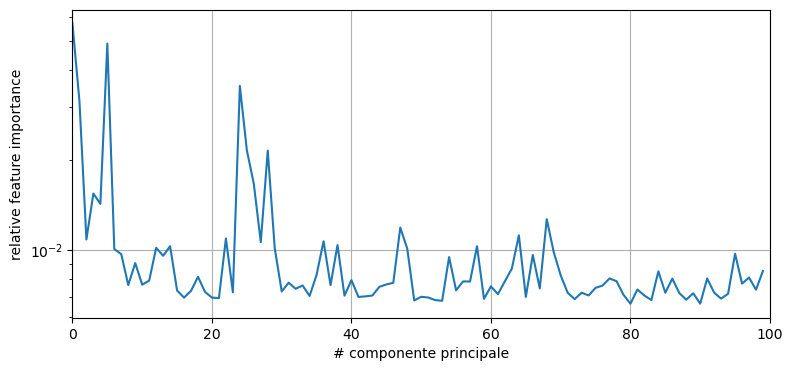

In [23]:
X_train_ = dimensionality_red(X_train, Vt, 100)
X_test_ = dimensionality_red(X_test, Vt, 100)

RF_optimal = RandomForestClassifier(n_estimators = 900 , random_state = 47, n_jobs = -1, criterion='gini')
RF_optimal.fit(X_train_, Y_train)
plt.figure(figsize=(9,4))
plt.plot(RF_optimal.feature_importances_, label = 'RF @ N_estimator = 900, N_pcomponents = 100')

plt.xlabel("# componente principale")
plt.xlim([0,100])
plt.ylabel("relative feature importance")
plt.yscale('log')
plt.grid(True)

plt.show()

Rispetto alla misura con una architettura non ottimizzata, la Feature Importance con la Random Forest ottimizzata tramite K-fold Cross validation presenta un grafico dell'andamento in funzione della componente principale meno rumoroso.

Infine, si confronta l'accuracy, sul dataset di test, del modello ottimizzato, rispettivamente senza e con la selezione delle feature in base alla loro importanza.

In [24]:
print('Accuracy del modello sul dataset di test:')

# Valutazione dell'accuracy senza la selezione delle feature più importanti
Y_pred = RF_optimal.predict(X_test_)
print('---> Senza la selezione delle feature più rilevanti: ',accuracy_score(Y_test,Y_pred))

from sklearn.feature_selection import SelectFromModel

# Selezione delle feature in base alla loro importanza
feature_selector = SelectFromModel(RF_optimal, threshold = 7e-3)
feature_selector.fit(X_train_, Y_train)

# Creazione di un nuvo dataset che riporta le feature più importanti
X_train_selected = feature_selector.transform(X_train_)
X_test_selected = feature_selector.transform(X_test_)

# Addestramento della Random Forest
RF_optimal.fit(X_train_selected, Y_train)

# L'accuratezza delle predizioni sul dataset di test è riportata in output
#print("Si ottiene una accuracy pari a: ", accuracy_score(Y_test,Y_pred))
print('---> Senza la selezione delle feature più rilevanti: ' ,  RF_optimal.score(X_test_selected, Y_test))

Accuracy del modello sul dataset di test:
---> Senza la selezione delle feature più rilevanti:  0.8217905405405406
---> Senza la selezione delle feature più rilevanti:  0.825168918918919


Si osserva che, dopo aver effettuato l'ottimizzazione della Random Forest con K-fold Cross Validation con Feature Importance (e conseguentemente escludendo le fature sotto soglia), se si effettua nuovamente una Feature importance prima di applicare il modello al dataset di test, l'accuracy finale non subisce un ulteriore incremento degno di nota, pur avendo impostato una nuova soglia di Relative Feature Importance al valore ottimale di $7 * 10^{-3}$.

Per finire, a partire dal modello ottimizzato con $900$ alberi e $100$ componenti principali, si valuta l'accuracy di modelli costruiti mantenendo fissati questi due iperparametri e facendone variare altri, ad esempio il $random \ state$ (seed del generatore di numeri pseudo-casuali per il bootstrapping e la feature selection) e il $max \ leaf \ nodes$ (numero massimo di nodi leaf degli alberi decisionali).

(6, 5)
xlabel =                [30, 40, 50] 3)/(3,3)
ylabel =                [15, 30, 60]


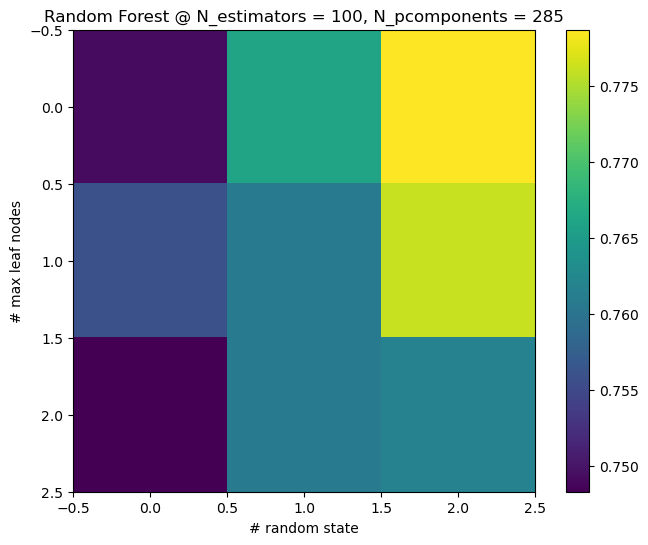

xlabel =                [30, 40, 50]
ylabel =                [15, 30, 60]


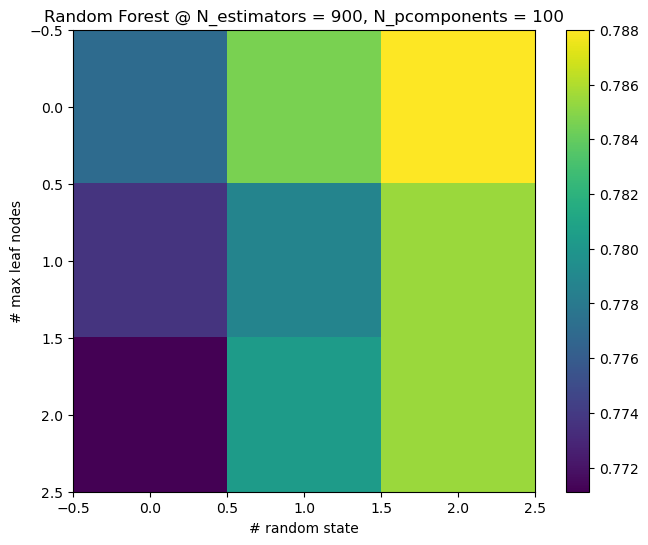

In [25]:
X_train, X_test, Y_train, Y_test = canonical_train_test_split(X_design)

# riduco la dimensionalità in base al numero j di componenti principali
X_train_red_final = dimensionality_red(X_train, Vt, 100)
X_test_red_final = dimensionality_red(X_test, Vt, 100)

leaf_range = [15,30,60]  #valori del numero di max_leaf_nodes
seed_range = [30, 40, 50]  #valori del numero di componenti principali incluse

# il risultato dell'ottimizzazione coarse-grain degli iperparametri è una heatmap che riporta l'accuracy in funzione di essi
accuracy_matrix_final = np.zeros((len(leaf_range) , len(seed_range)))
print(np.shape(accuracy_matrix_final))

# confronto i risutati con la random forest non ottimizzata
accuracy_matrix_init = np.zeros((len(leaf_range) , len(seed_range)))

X_train_red_init = dimensionality_red(X_train, Vt, 285)
X_test_red_init = dimensionality_red(X_test, Vt, 285)

i1 = 0          # serve solo come contatore per il messaggio di output
for i in seed_range:
    j1 = 0      #serve solo come contatore per il messaggio di output
    for j in leaf_range:
        
        #Definisco la random forest non ottimizzata
        RF_init = RandomForestClassifier(n_estimators = 100 , random_state = i, max_leaf_nodes = j, n_jobs = -1, criterion='gini')
        
        #Definisco la random forest ottimizzata
        RF_final = RandomForestClassifier(n_estimators = 900 , random_state = i, max_leaf_nodes = j, n_jobs = -1, criterion='gini')

        # Addestramento della Random Forest
        RF_init.fit(X_train_red_init, Y_train)
        RF_final.fit(X_train_red_final, Y_train)
        
        Y_pred_init = RF_init.predict(X_test_red_init)
        Y_pred_final = RF_final.predict(X_test_red_final)
        
        accuracy_matrix_init[i1 , j1] = accuracy_score(Y_test, Y_pred_init)
        accuracy_matrix_final[i1 , j1] = accuracy_score(Y_test, Y_pred_final)
        print(f'Eseguita la Random Forest numero {(i1 + 1,j1 + 1)}/(3,3)' , end = '\r')
        j1 = j1 + 1
    i1 = i1 + 1
       
plt.figure(figsize=(8,6))
plt.title("Random Forest @ N_estimators = 100, N_pcomponents = 285")
plt.imshow(accuracy_matrix_init)
plt.colorbar()
plt.xlabel("# random state")
print("xlabel =               " , seed_range)
plt.ylabel("# max leaf nodes")
print("ylabel =               " , leaf_range)
plt.show()

plt.figure(figsize=(8,6))
plt.title("Random Forest @ N_estimators = 900, N_pcomponents = 100")
plt.imshow(accuracy_matrix_final)
plt.colorbar()
plt.xlabel("# random state")
print("xlabel =               " , seed_range)
plt.ylabel("# max leaf nodes")
print("ylabel =               " , leaf_range)
plt.show()

Dal confronto tra le Random Forest non ottimizzate (con $100$ alberi e $285$ componenti principali) e quelle ottimizzate con la K-Fold Cross Validation ($900$ alberi e $100$ componenti principali), si evince come il miglioramento dell'accuracy dal primo al secondo caso sia robusto al variare degli iperparametri di $random \ seed$ e $max \ leaf \ nodes$.

**5. Conclusioni**
    
In questo Notebook si è scelto di affrontare un problema di classificazione binaria utilizzando come modello la Random Forest. 
Esso non rappresenta tuttavia l'architettura più efficiente per ottenere dei predittori con accuratezza massimizzata. Infatti, le Reti Neurali Convoluzionali sono decisamente più adatte al riconoscimento di immagini, dal momento che, anzichè linearizzare le singole istanze, tali architetture addestrano i modelli sulle immagini in formato matriciale, riuscendo ad analizzare le informazioni a livello locale per individuare specifici pattern tra i pixel adiacenti.

Nonostante la Random Forest non sia l'architettura più efficiente per la classificazione di immagini, è stato possibile portare l'accuratezza delle sue predizioni oltre l'$80 \%$ grazie alla K-fold Cross Validation, che generalizza il modello rendendolo il meno dipendente possibile dal dataset su cui è addestrato.